In [1]:
import torch
import os
import tiktoken
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import json
import os
from tqdm import tqdm
import tiktoken
import h5py
import numpy as np

device = 'mps'

In [2]:
enc = tiktoken.get_encoding('r50k_base')

In [3]:
from data_utils import get_batch_iterator

batch_size = 32
context_length = 128

train_batch_iterator = get_batch_iterator('train', batch_size=32, context_length=128)

In [10]:
xb, yb = next(train_batch_iterator)
print(xb.shape, yb.shape)
for row in xb:
    print(enc.decode(row.tolist()))
    print('\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n')

torch.Size([32, 128]) torch.Size([32, 128])
 rather than in Paris.

Emmanuel Pastoret published in 1787 his Zoroaster, Confucius and Muhammad, in which he presents the lives of these three "great men", "the greatest legislators of the universe", and compares their careers as religious reformers and lawgivers. He defends Islam's prophet, too often calumniated as an impostor. In fact, the Qur'an proffers "the most sublime truths of cult and morals" (234); it defines the unity of God with an "admirable concision" (236). The common accusations of the Prophet's immorality are


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


4\pi}
K^{\sigma\sigma'}_{IJ}\partial_x\phi_I^\sigma\partial_t\phi_J^{\sigma'}{
+\frac{1}{2\pi}t^{\sigma}_{I}\epsilon^{\mu\nu}\partial_{\mu}\phi^{\
\sigma}_IA_{\nu}}  \label{interfaceK}\end{aligned}$$ where $\sigma=0,1=R,L$ labels right and left moving modes, $\phi^R_


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


                                                      

In [5]:
def count_params(m):
    print(sum(p.numel() for p in m.parameters()))

In [6]:
from transformer import Transformer as MyTransformer

model = MyTransformer()
model = model.to(device)
print(model)
count_params(model)

Transformer(
  (token_embed): Embedding(50304, 128)
  (position_embed): Embedding(128, 128)
  (attn_block): Block(
    (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (heads): ModuleList(
        (0-7): 8 x Head(
          (key): Linear(in_features=128, out_features=16, bias=False)
          (query): Linear(in_features=128, out_features=16, bias=False)
          (value): Linear(in_features=128, out_features=16, bias=False)
        )
      )
    )
    (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (hidden): Linear(in_features=128, out_features=512, bias=True)
      (relu): ReLU()
      (proj): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=50304, bias=True)
)
13126144


In [18]:
eval_iters = 20

@torch.no_grad()
def estimate_loss(steps=eval_iters):
    out = {}
    model.eval()
    for split in ['dev', 'train']:
        batch_iterator = get_batch_iterator(split)
        losses = torch.zeros(steps)
        for k in tqdm(range(steps)):
            xb, yb = next(batch_iterator)
            _, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [19]:
estimate_loss(100)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

383326404


  0%|                                                   | 0/100 [00:00<?, ?it/s]

37402359179


100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


{'dev': tensor(4.4166), 'train': tensor(4.3440)}

In [272]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

  0%|                                                 | 0/40000 [00:00<?, ?it/s]

37402359179


Train loss: 4.3158:   0%|                  | 1/40000 [00:07<83:14:03,  7.49s/it]

decaying_lr


Train loss: 4.3641: 100%|███████████████| 40000/40000 [1:51:23<00:00,  5.99it/s]


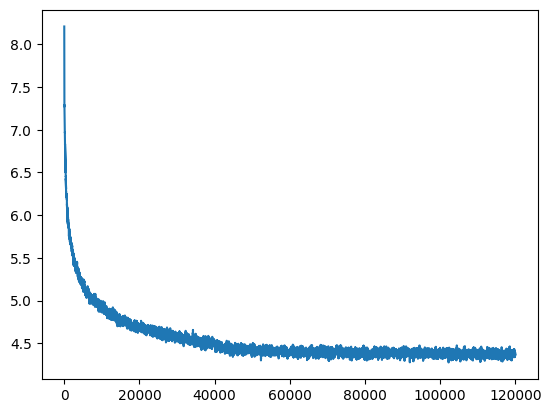

  0%|▏                                          | 1/200 [00:00<00:22,  8.94it/s]

383326404


  0%|                                                   | 0/200 [00:00<?, ?it/s]

37402359179


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.90it/s]


{'dev': tensor(4.3805), 'train': tensor(4.3434)}

In [281]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
context_length = 128
n_steps = 40000
decay_lr_step = 0
avg_window = 64

batch_iterator = get_batch_iterator('train', batch_size, context_length)

pbar = tqdm(enumerate(range(n_steps)), total=n_steps)
for i, steps in pbar:
    xb, yb = next(batch_iterator)
    logits, loss = model(xb, yb)
    losses.append(loss.item())
    pbar.set_description(f"Train loss: {np.mean(losses[-avg_window:]):.4f}")
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if i == decay_lr_step:
        print('decaying_lr')
        for g in optimizer.param_groups:
            g['lr'] = 2e-5

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(losses, avg_window))
plt.show()
estimate_loss(200)

In [274]:
for g in optimizer.param_groups:
    g['lr'] = 1e-4

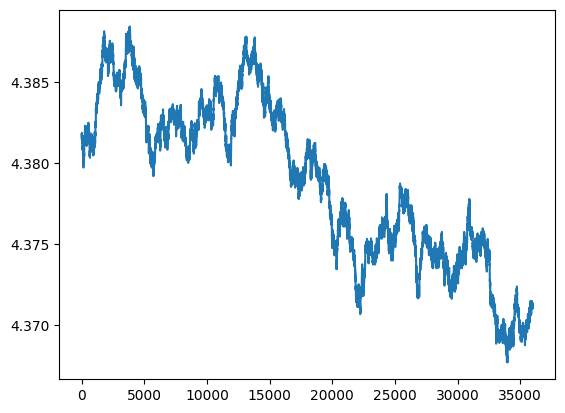

In [285]:
plt.plot(moving_average(losses[-40000:], 4000))
plt.show()

In [283]:
train_loss, dev_loss = estimate_loss(1000).values()
train_loss, dev_loss

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

383326404


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

37402359179


100%|███████████████████████████████████████| 1000/1000 [01:09<00:00, 14.33it/s]


(tensor(4.3919), tensor(4.3741))

In [7]:
model_path = "/Users/jake/personal/monosemantic/models/transformer_pile_2_128_0_4.3741.pt"

In [187]:
os.makedirs('models', exist_ok=True)

if not os.path.exists(model_path):
    torch.save({
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                # 'losses': losses,
                # 'train_loss': train_loss,
                # 'dev_loss': dev_loss,
                # 'steps': len(losses),
                }, model_path)

In [8]:
checkpoint = torch.load(model_path)
# model = Transformer().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
checkpoint['steps']

120000

In [17]:
idx = torch.tensor(enc.encode('<|endoftext|>', allowed_special={'<|endoftext|>'}), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate(idx, 128)[0].tolist()))

<|endoftext|>(Bention by abb atoms)?
The goal-learning to study position over this opinion (used) at the
Class of the Census Survey. We also present work, and results in awarding AVs included in the AmAgaiAndaker mathematical elements and the idea of this paper can be accessed with spheres and the major habitat system (inearus) the case of matrix israeliere's Moldova chausto (massXXG; and by the main focus) makes fun deviate.

a gold range, organic, cold oil, copper silicon material, and aluminum, such asen decorative sand is


In [183]:
# batch_size = 256

# num_batches = len(train_data)

# def iterate_data(split, batch_size=batch_size):
#     data = train_data if split == 'train' else dev_data
#     rows = data[:len(data) - len(data) % (context_length*batch_size)].view(-1, batch_size, context_length)
#     print(f"batches: {rows.shape[0]}")
#     for batch in rows:
#         yield batch

# batch_iterator = iterate_data('train')

In [184]:
# import h5py

# hdf5_path = 'data/embeddings_0.hdf5'

# with h5py.File(hdf5_path, 'w') as hdf5_file:
#     with torch.no_grad():
#         maxshape = (None, n_embed*4)
#         dataset = hdf5_file.create_dataset('tensors', (0, n_embed*4), maxshape=maxshape, dtype='float32')
        
#         for batch in tqdm(batch_iterator):
#             embedding = model.forward_embedding(batch.to(device))
#             flattened_embedding = embedding.view(-1, n_embed*4)
    
#             # Append the flattened tensor to the HDF5 dataset
#             dataset.resize((dataset.shape[0] + flattened_embedding.shape[0]), axis=0)
#             dataset[-flattened_embedding.shape[0]:] = flattened_embedding.cpu().numpy()


In [185]:
# import numpy as np

# batch_size = 128

# def iterate_embeddings(batch_size):
#     with h5py.File(hdf5_path, 'r') as hdf5_file:
#         while True:
#             dataset = hdf5_file['tensors']
#             dataset_size = dataset.shape[0]
#             random_indices = torch.randint(dataset_size, size=(batch_size,))
#             random_samples = torch.tensor(np.array([dataset[idx] for idx in random_indices]))
#             yield random_samples

# embedding_iterator = iterate_embeddings(batch_size)

In [86]:
# next(embedding_iterator).shape

torch.Size([128, 512])

In [102]:
n_features = 512

autoencoder = SparseAutoencoder(n_features).to(device)
count_params(autoencoder)
autoencoder

525312


SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=512, bias=True)
  (decoder): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
)

In [26]:
def get_embedding_iterator(split, batch_size, context_length=context_length):
    batch_iterator = get_batch_iterator(split, batch_size, context_length)
    while True:
        xb, _ = next(batch_iterator)
        with torch.no_grad():
            x_embedding, _ = model.forward_embedding(xb)
        random_idxs = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities
        yield filtered_xe

In [303]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [165]:
train_steps = 100000
lambda_reg = 0.003
batch_size = 512
lr = 1e-6

autoencoder = SparseAutoencoder(1024).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
losses = []
recon_losses = []
reg_losses = []
autoencoder

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
)

  0%|                                                | 0/100000 [00:00<?, ?it/s]

37402359179


Recon: 0.121 Reg: 0.058: 100%|████████| 100000/100000 [6:44:07<00:00,  4.12it/s]

Loss:	0.179
Recon:	0.122
Reg:	0.057


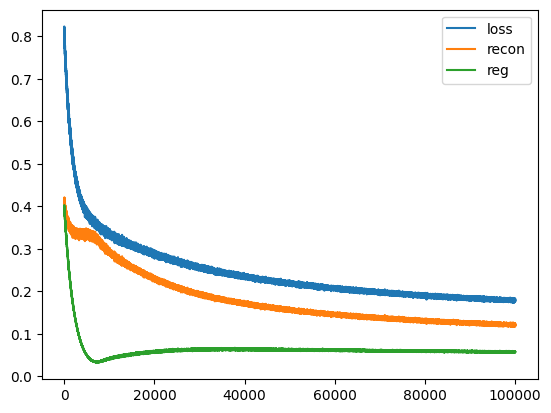

In [166]:
import matplotlib.pyplot as plt
import h5py

# train_steps = 40000
# batch_size = 512
losses = []
recon_losses = []
reg_losses = []
batch_iterator = get_batch_iterator('train', batch_size, context_length)

pbar = tqdm(range(train_steps))

for _ in pbar:
    xb, _ = next(batch_iterator)
    with torch.no_grad():
        x_embedding, _ = model.forward_embedding(xb)
    random_idxs = torch.randint(context_length, (batch_size,))
    filtered_xe = x_embedding[range(batch_size), random_idxs, :]  # only take one sample per batch element to avoid local similarities

    # x_embedding = next(embedding_iterator).to(device)
    optimizer.zero_grad()
    outputs, recon_loss, reg_loss = autoencoder(filtered_xe, compute_loss=True)
    reg_loss = lambda_reg * reg_loss
    loss = recon_loss + reg_loss
    loss.backward()
    optimizer.step()
    autoencoder.normalize_decoder_weights()
    
    losses.append(loss.item())
    recon_losses.append(recon_loss.item())
    reg_losses.append(reg_loss.item())

    pbar.set_description(f"Recon: {np.mean(recon_losses[-100:]):.3f} Reg: {np.mean(reg_losses[-100:]):.3f}")

print(f"Loss:\t{loss:.3f}\nRecon:\t{recon_loss:.3f}\nReg:\t{reg_loss:.3f}")
plt.plot(losses, label='loss')
plt.plot(recon_losses, label='recon')
plt.plot(reg_losses, label='reg')
plt.legend()
plt.show()

In [169]:
autoencoder

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
)

In [177]:
path = "models/autoencoder_pile_2_true_1024_feats_0.003_1e-6.pt"

os.makedirs('models', exist_ok=True)

if not os.path.exists(path):
    torch.save({
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'steps': len(losses),
                }, path)

In [167]:
print(lambda_reg)

0.003


In [9]:
from autoencoder import SparseAutoencoder as MySparseAutoencoder

path = "models/autoencoder_pile_2_true_512_feats_0.003_1e-6.pt"

checkpoint = torch.load(path)
autoencoder = MySparseAutoencoder(n_features = 512).to(device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [21]:
autoencoder

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=512, bias=True)
  (decoder): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
)

In [11]:
identity = lambda x: (x, None, None)
idx = torch.tensor(enc.encode('<|endoftext|>', allowed_special={'<|endoftext|>'}), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate_ablated(idx, 128, autoencoder)[0].tolist()))

<|endoftext|>2/00.

Can the put effect of 2, I had an easy for this part have in the same time (or) that was all those types, the $40.
The Green for the last time or the same. I had made it to extend the same to the group of the product is a third. Eice, the 7, which typically becomes significant (perp) is an experimental clue to the acrylic-f-f-b-w-417s' mass which can use the *m.

As such as Behold as a sub-body product is a given by the exact c


In [170]:
import matplotlib.pyplot as plt

batch_size = 512
embedding_iterator = get_embedding_iterator('train', batch_size)

def feature_density_histogram(num_samples=16384):
    all_outputs = []
    for i in tqdm(range(num_samples // batch_size)):
        batch = next(embedding_iterator).to(device)
        outputs = autoencoder.encode(batch)  # (128, 4096)
        all_outputs.append(outputs)
    all_outputs = torch.concat(all_outputs)
    return all_outputs

with torch.no_grad():
    activation_densities = feature_density_histogram(16384*10)
B, C = activation_densities.shape
activation_densities = (activation_densities > 0).to(torch.float32).mean(dim=0)
activation_densities = activation_densities[activation_densities > 0]
activation_densities = activation_densities.log10().cpu().tolist()
print(len(activation_densities)/C)
plt.hist(activation_densities, bins=48)
plt.show()

# We want nearly all features to be below 1% density: "The number of features with density above 1%. A significant number of features above this level seems to correspond to an L1 coefficient that is too low."

  0%|                                                   | 0/320 [00:00<?, ?it/s]

37402359179


 82%|█████████████████████████████████▍       | 261/320 [01:23<00:18,  3.11it/s]


KeyboardInterrupt: 

In [279]:
(activation_densities > -1).sum()

tensor(42, device='mps:0')

In [35]:
print(f"{(((activation_densities > 0).to(torch.float32).mean(dim=0) > 0).sum().item() / 4096 * 100):.2f}%")

TypeError: '>' not supported between instances of 'list' and 'int'

In [175]:
batch_size = 4096
embedding_iterator = get_embedding_iterator('train', batch_size)
x_embedding = next(embedding_iterator).to(device)

activation_counts = (autoencoder.encode(x_embedding) > 1e-3 * 1.0).sum(dim=-1).to(torch.float32)
print(f"Median:\t{activation_counts.median().item()}\nMean:\t{activation_counts.mean().item():.2f}\nStd:\t{activation_counts.std().item():.2f}")
# median number of hot features per token for each element in the batch, want to be "less than 10 or 20" as per paper

# "we generally target a L^0 norm that is less than 10 or 20. We especially distrust solutions where the L^0 norm is a significant fraction of the transformer’s activation dimensionality.

37402359179
Median:	35.0
Mean:	34.30
Std:	7.59


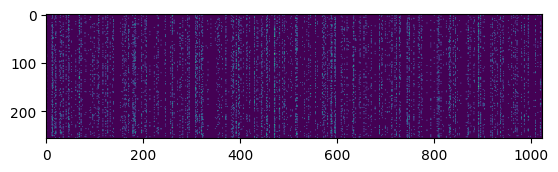

In [176]:
with torch.no_grad():
    out = autoencoder.encode(x_embedding) > 1e-3
B, C = out.shape
plt.imshow(out.cpu()[:256, :])

In [101]:
!git a && git c 'best results so far' && git push origin main

[main 653f1b9] best results so far
 1 file changed, 2523 insertions(+), 2358 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 11 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 69.38 KiB | 8.67 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/jnward/monosemanticity-repro.git
   536ef8a..653f1b9  main -> main


In [13]:
batch_iterator = get_batch_iterator('train', 32, 128)
xb, yb = next(batch_iterator)
print(xb.shape)

with torch.no_grad():
    t_logits, t_loss = model(xb, yb)
    a_logits, a_loss = model.forward_ablated(xb, autoencoder, yb)

print(t_loss, a_loss)

37402359179
torch.Size([32, 128])
tensor(4.1220, device='mps:0') tensor(4.8441, device='mps:0')


In [172]:
def get_features(x):
    embedding, _ = model.forward_embedding(x)
    features = autoencoder.encode(embedding)
    return features

features = get_features(xb)

print(features.shape, xb.shape)

torch.Size([32, 128, 1024]) torch.Size([32, 128])


In [173]:
feature_dict = {i: [0, []] for i in range(4096)}
context_list = []

threashold = 1e-5

num_iters = 32000
batch_size = 16
samples_per_row = 4

batch_iterator = get_batch_iterator('train', batch_size, 128)

for _ in tqdm(range(num_iters)):
    xb, _ = next(batch_iterator)
    features = get_features(xb)
    features = features.cpu()
    # print(features)
    for i, row in enumerate(xb):  # iterate thru rows in a batch
        # for j in range(row.shape[0]):  # iterate thru tokens in a row
        for j in np.random.choice(row.shape[0], samples_per_row, replace=False):  #torch.randint(row.shape[0], (samples_per_row,), replact=False):
            token = row[j]
            context = row[max(j-4, 0):j+5]
            context_list.append((token.item(), context.tolist()))
            context_idx = len(context_list) - 1
            
            feature_vec = features[i, j]
            # print(feature_vec.shape)
            activation_idxs = (feature_vec > threashold).nonzero()
            # print(activation_idxs.shape)
            # print(activation_idxs)

            for a_idx in activation_idxs:
                a_idx = a_idx[0].item()
                feature_dict[a_idx][0] += 1
                if feature_dict[a_idx][0] < 512:
                    feature_dict[a_idx][1].append((context_idx, feature_vec[a_idx].item()))



  0%|                                                 | 0/32000 [00:00<?, ?it/s]

37402359179


100%|█████████████████████████████████████| 32000/32000 [15:01<00:00, 35.48it/s]


In [174]:
sorted_dict = sorted(feature_dict.items(), key = lambda x: x[1][0] if 20000 > x[1][0] >= 4 else 0, reverse=True)

a = 0
# for feat_idx, info in feature_dict.items():
for feat_idx, info in sorted_dict[:100]:
    a += 1
    if a >= 10000:
        break
    count = info[0]
    ctxs = sorted(info[1], key=lambda x: x[1], reverse=True)
    ctxs = [ctx for ctx in ctxs if ctx[1] > 0.1]
    # ctxs = info[1]
    print(f"Feature idx:\t{feat_idx}\nCount:\t\t{count}")
    for context_idx, feature_activation in ctxs[:10]:
        token_idx = context_list[context_idx][0]
        token = enc.decode([token_idx])
        context = enc.decode(context_list[context_idx][1])
        print(f'  Token: {repr(token)}\n  Token Index: {token_idx}\n  Context: {repr(context)}\n  Activation: {feature_activation:.3f}')
        print()

Feature idx:	71
Count:		18765
  Token: '10'
  Token Index: 940
  Context: '1022\nIn base'
  Activation: 1.279

  Token: '32'
  Token Index: 2624
  Context: '32…….but the'
  Activation: 1.271

  Token: '28'
  Token Index: 2078
  Context: '28, P \\<'
  Activation: 1.248

  Token: '14'
  Token Index: 1415
  Context: '14;\n  '
  Activation: 1.239

  Token: '23'
  Token Index: 1954
  Context: '23.BIN">'
  Activation: 1.215

  Token: ' nodes'
  Token Index: 13760
  Context: ' nodes can go back to'
  Activation: 1.132

  Token: '2'
  Token Index: 17
  Context: '2 teaspoons olive oil\n'
  Activation: 1.103

  Token: '2'
  Token Index: 17
  Context: '2 ) \\theta'
  Activation: 1.103

  Token: 'ku'
  Token Index: 23063
  Context: 'kuapp.com/'
  Activation: 1.097

  Token: ' caller'
  Token Index: 24955
  Context: ' caller.\n\nThe'
  Activation: 1.061

Feature idx:	294
Count:		18549
  Token: 'и'
  Token Index: 18849
  Context: ' проис�'
  Activation: 2.035

  Token: 'и'
  Token Index: 18849
  Con

In [114]:
math.log10(0)

ValueError: math domain error

In [63]:
!git a && git commit -m "captured a few somewhat interesting features"

[main 536ef8a] captured a few somewhat interesting features
 1 file changed, 2987 insertions(+), 5115 deletions(-)


In [64]:
!git push origin main

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 11 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 176.84 KiB | 16.08 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/jnward/monosemanticity-repro.git
   685d842..536ef8a  main -> main


In [5]:
import zstandard as zstd
import json

# Path to your .jsonl.zst file
file_path = '/Volumes/External/EleutherAI_ThePile_v1/pile/val.jsonl.zst'

# Open the compressed file
with open(file_path, 'rb') as compressed:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed) as reader:
        while True:
            chunk = reader.read(65536)  # Read a chunk of data
            if not chunk:
                break
            # Process chunk (which is a part of your decompressed data)
            for line in chunk.splitlines():
                json_data = json.loads(line.decode('utf-8'))
                break
            break
                # Process your json_data here

{'pile_set_name': 'OpenWebText2'}


In [181]:
!git a && git c "scripts for using the pile"


[main f8ebab5] scripts for using the pile
 1 file changed, 404 insertions(+), 4868 deletions(-)
